In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import PIL.Image as Image
import matplotlib.pyplot as plt
import cv2

In [3]:
import tensorflow_hub as hub

#특징 추출기 불러오기( 완전연결계층 X / input_shape 또한 따로 특정되지 않음 / 사전 훈련 x )
res_url = 'https://tfhub.dev/tensorflow/resnet_50/feature_vector/1'
feature_model = tf.keras.Sequential([
    hub.KerasLayer(res_url, 
                   output_shape=(2048,), 
                   trainable=False)
])
feature_model.build([None, 224, 224, 3])
feature_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              23561152  
Total params: 23,561,152
Trainable params: 0
Non-trainable params: 23,561,152
_________________________________________________________________


In [4]:
feature_model.build([None, 224, 224, 3])
feature_model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              23561152  
Total params: 23,561,152
Trainable params: 0
Non-trainable params: 23,561,152
_________________________________________________________________


In [5]:
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_resnet_v2 import preprocess_input

image_size = 224
batch_size = 1

# 학습 및 검증 데이터용 ImageDataGenerator 생성해 놓기 
train_datagen = ImageDataGenerator(rescale=1./255., 
                                #    horizontal_flip = True, 
                                #    shear_range = 0.2,
                                #    zoom_range = 0.2,
                                #    width_shift_range = 0.2,
                                #    height_shift_range = 0.2,
                                   validation_split = 0.25)

#검증데이터는 정규화 외에 따로 조정 없음 
valid_datagen = ImageDataGenerator(rescale=1./255., 
                                   validation_split = 0.25)

#flow_from_directory()는 앞서 배운 flow()와 비슷, 단 경로를 통채로 가져올 수 있음 
train_generator = train_datagen.flow_from_directory(directory = '/content/drive/My Drive/covid data final', #저장 경로 
                                                    subset = 'training',   
                                                    batch_size = batch_size,
                                                    seed = 126,
                                                    shuffle = True,
                                                    class_mode = 'categorical',
                                                    target_size = (image_size,image_size))

valid_generator = valid_datagen.flow_from_directory(directory = '/content/drive/My Drive/covid data final',
                                                    subset = 'validation',
                                                    batch_size = 1,
                                                    seed = 126,
                                                    shuffle = True,
                                                    class_mode = 'categorical',
                                                    target_size = (image_size,image_size))


Found 9258 images belonging to 3 classes.
Found 3084 images belonging to 3 classes.


In [6]:
# 학습데이터의 3배정도 이미지가 보강되도록 한다.
import numpy as np

image_size = 224
batch_size = 1

# batch_step = (9258* 3 )// batch_size #데이터 증폭 시켜 배치 스텝을 구해준다.(120회)
train_features = [] # 빈 리스트 생성 
train_Y = [] # 빈 리스트 생성 

for idx in range(train_generator.n): #스텝 만큼 반복
  if idx % 10 == 0: #만약 0 포함 100의 배수일때
    print(idx) #배치스텝 반환 (진행상황 표기)
  x, y = train_generator.next() #next()를 활용하여 train_generator에 담겨진 [[입력픽셀],[라벨링]] 을 x와 y에 담아 준다. 
  train_Y.extend(y) #append()와 비슷한 기능, list에 appending 수행
  
  # feature_model : 이미 학습이 완료된 특징 추출기 (우리가 불러옴)
  # 학습데이터 x 를 활용해서 feature_model을 통과시켜 특징 추출.
  feature = feature_model.predict(x)
  train_features.extend(feature)

#array 전환 
train_features = np.array(train_features)
train_Y = np.array(train_Y)

print(train_features.shape)
print(train_Y.shape)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2

In [7]:
valid_features = [] # 빈 리스트 생성 
valid_Y = [] # 빈 리스트 생성 

for idx in range(valid_generator.n): ## valid_generator.n = 1285 (검증데이터의 수)
  if idx % 100 == 0: #만약 0 포함 100의 배수일때
    print(idx) #배치스텝 반환 (진행상황 표기)
  x, y = valid_generator.next() #next()를 활용하여 valid_generator에 담겨진 [[입력픽셀],[라벨링]] 을 x와 y에 담아 준다.   
  valid_Y.extend(y) #append()와 비슷한 기능, list에 appending 수행
  
  # feature_model : 이미 학습이 완료된 특징 추출기 (우리가 불러옴)
  # 학습데이터 x 를 활용해서 feature_model을 통과시켜 특징 추출.
  feature = feature_model.predict(x)
  valid_features.extend(feature)

#array 전환 
valid_features = np.array(valid_features)
valid_Y = np.array(valid_Y)

print(valid_features.shape)
print(valid_Y.shape)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
(3084, 2048)
(3084, 3)


In [53]:
model = tf.keras.Sequential([
                             tf.keras.layers.Dense(256, activation= 'relu', input_shape = (2048,)),
                             tf.keras.layers.Dropout(0.5),
                             tf.keras.layers.Dense(3,activation='softmax')
])
model.compile(tf.optimizers.RMSprop(0.0001), 
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 256)               524544    
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 3)                 771       
Total params: 525,315
Trainable params: 525,315
Non-trainable params: 0
_________________________________________________________________


In [54]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint_path = '/content/drive/My Drive/check.h5'

cp = ModelCheckpoint(filepath=checkpoint_path,
                                save_weights_only=True,
                                save_best_only=True,
                                monitor='val_accuracy',
                                verbose=1)

es = EarlyStopping(patience=50, verbose=1)
history = model.fit(train_features, train_Y, 
                    validation_data=(valid_features, valid_Y),
                    epochs = 100,
                    batch_size = 32,
                    callbacks=[es,cp])
model.summary()


Epoch 1/100
282/290 [============================>.] - ETA: 0s - loss: 0.3810 - accuracy: 0.8563
Epoch 00001: val_accuracy improved from -inf to 0.90661, saving model to /content/drive/My Drive/check.h5
290/290 [==============================] - 2s 5ms/step - loss: 0.3773 - accuracy: 0.8582 - val_loss: 0.2405 - val_accuracy: 0.9066
Epoch 2/100
289/290 [============================>.] - ETA: 0s - loss: 0.1894 - accuracy: 0.9321
Epoch 00002: val_accuracy improved from 0.90661 to 0.93904, saving model to /content/drive/My Drive/check.h5
290/290 [==============================] - 1s 3ms/step - loss: 0.1894 - accuracy: 0.9321 - val_loss: 0.1729 - val_accuracy: 0.9390
Epoch 3/100
290/290 [==============================] - ETA: 0s - loss: 0.1567 - accuracy: 0.9439
Epoch 00003: val_accuracy did not improve from 0.93904
290/290 [==============================] - 1s 3ms/step - loss: 0.1567 - accuracy: 0.9439 - val_loss: 0.1858 - val_accuracy: 0.9355
Epoch 4/100
281/290 [=========================

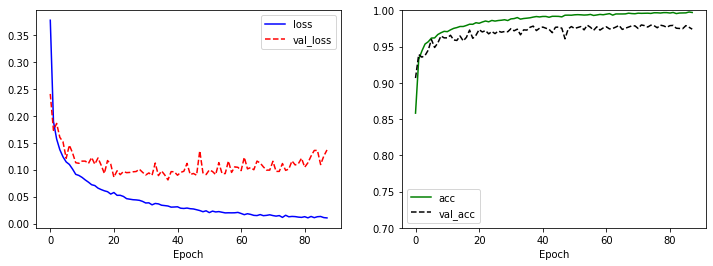

In [55]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12,4))
 
plt.subplot(1,2,1)
plt.plot(history.history['loss'], 'b-', label = 'loss')
plt.plot(history.history['val_loss'], 'r--', label = 'val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], 'g-', label = 'acc')
plt.plot(history.history['val_accuracy'], 'k--', label = 'val_acc')
plt.xlabel('Epoch')
plt.ylim([0.7, 1])
plt.legend()

plt.show()

In [56]:
results = model.evaluate(valid_features, valid_Y)
print('Test accuracy: ', results[1])

97/97 [==============================] - 0s 2ms/step - loss: 0.1365 - accuracy: 0.9741
Test accuracy:  0.9740596413612366


In [57]:
model.save('/content/drive/My Drive/Resnet_model_14.h5')

['COVID19', 'COVID19', 'NORMAL', 'PNEUMONIA', 'PNEUMONIA']
[0, 0, 1, 2, 2]
[0, 0, 1, 2, 2]


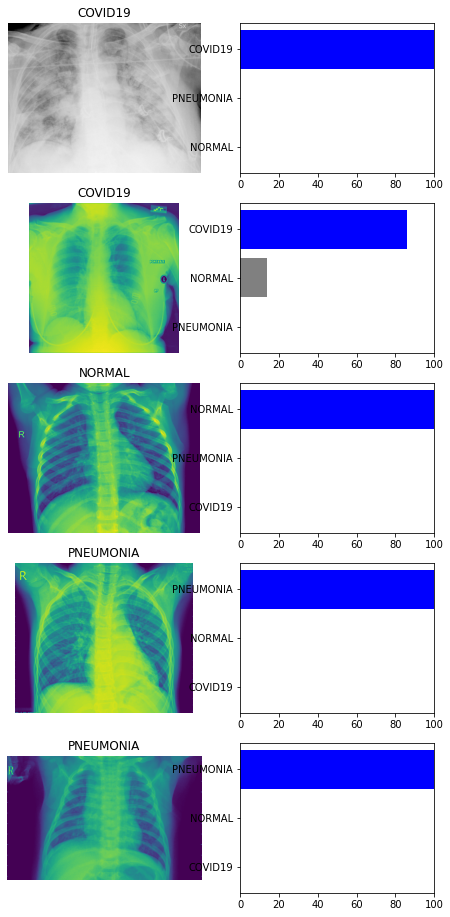

In [62]:
import random
real_Y = []
real_Y_index =[]
predict_Y =[]
unique_sorted_Y =['COVID19','NORMAL','PNEUMONIA']

plt.figure(figsize=(16,16))

for i in range(5): 
  image_path = random.choice(valid_generator.filepaths) 

  plt.subplot(5,4,i*4+1)
          
  plt.imshow(plt.imread(image_path))

  real_y = image_path.split('/')[5]
  real_Y.append(real_y)

  plt.title(real_y)
  plt.axis('off')

  idx = unique_sorted_Y.index(real_y)
  real_Y_index.append(idx)

  plt.subplot(5,4,i * 4+2)
  img = cv2.imread(image_path)
  img = cv2.resize(img, dsize=(224,224))
  img = img / 255.0

  img = np.expand_dims(img, axis=0)

  feature_vector = feature_model.predict(img)

  prediction = model.predict(feature_vector)[0]

  top_3_predict = prediction.argsort()[::-1]
  predict_Y.append(top_3_predict[0])

  labels = [unique_sorted_Y[index] for index in top_3_predict]
  color = ['gray'] * 3

  if idx in top_3_predict:
    color[top_3_predict.tolist().index(idx)] = 'blue'
  color = color[::-1]

  plt.barh(range(3), prediction[top_3_predict][::-1] * 100, color = color)
  plt.yticks(range(3), labels[::-1])
  plt.xlim([0, 100])

print(real_Y)
print(real_Y_index)
print(predict_Y)

In [63]:
import random
real_Y = []
real_Y_index =[]
predict_Y =[]

plt.figure(figsize=(16,16))

for i in range(1000): 
  image_path = random.choice(valid_generator.filepaths) 

  real_y = image_path.split('/')[5]
  real_Y.append(real_y)

  idx = unique_sorted_Y.index(real_y)
  real_Y_index.append(idx)

  img = cv2.imread(image_path)
  img = cv2.resize(img, dsize=(224,224))
  img = img / 255.0

  img = np.expand_dims(img, axis=0)

  feature_vector = feature_model.predict(img)

  prediction = model.predict(feature_vector)[0]

  top_3_predict = prediction.argsort()[::-1]
  predict_Y.append(top_3_predict[0])

  labels = [unique_sorted_Y[index] for index in top_3_predict]

print(real_Y)
print(real_Y_index)
print(predict_Y)

['NORMAL', 'PNEUMONIA', 'NORMAL', 'NORMAL', 'NORMAL', 'NORMAL', 'PNEUMONIA', 'NORMAL', 'NORMAL', 'NORMAL', 'PNEUMONIA', 'NORMAL', 'NORMAL', 'NORMAL', 'PNEUMONIA', 'NORMAL', 'NORMAL', 'PNEUMONIA', 'NORMAL', 'PNEUMONIA', 'NORMAL', 'NORMAL', 'COVID19', 'PNEUMONIA', 'PNEUMONIA', 'COVID19', 'COVID19', 'NORMAL', 'PNEUMONIA', 'NORMAL', 'NORMAL', 'PNEUMONIA', 'NORMAL', 'NORMAL', 'PNEUMONIA', 'NORMAL', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'NORMAL', 'PNEUMONIA', 'NORMAL', 'COVID19', 'NORMAL', 'NORMAL', 'NORMAL', 'NORMAL', 'PNEUMONIA', 'NORMAL', 'NORMAL', 'COVID19', 'PNEUMONIA', 'NORMAL', 'NORMAL', 'PNEUMONIA', 'NORMAL', 'PNEUMONIA', 'NORMAL', 'NORMAL', 'NORMAL', 'PNEUMONIA', 'NORMAL', 'NORMAL', 'NORMAL', 'PNEUMONIA', 'NORMAL', 'NORMAL', 'PNEUMONIA', 'NORMAL', 'NORMAL', 'NORMAL', 'NORMAL', 'NORMAL', 'NORMAL', 'NORMAL', 'PNEUMONIA', 'NORMAL', 'COVID19', 'NORMAL', 'NORMAL', 'NORMAL', 'PNEUMONIA', 'PNEUMONIA', 'NORMAL', 'NORMAL', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'NO

<Figure size 1152x1152 with 0 Axes>

#multi-calss classification 
confusion matrix

In [64]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(real_Y_index,predict_Y)
cm

array([[ 95,  12,   3],
       [  0, 465,  18],
       [  1,   3, 403]])

In [65]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 95  12   3]
 [  0 465  18]
 [  1   3 403]]


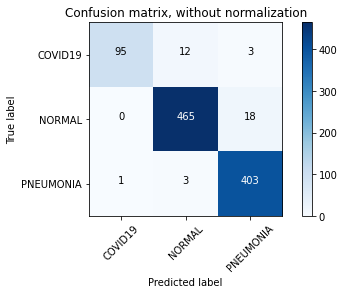

In [66]:
plt.figure()
plot_confusion_matrix(cm, classes=unique_sorted_Y, title='Confusion matrix, without normalization')
plt.savefig('Resnet50.jpg')

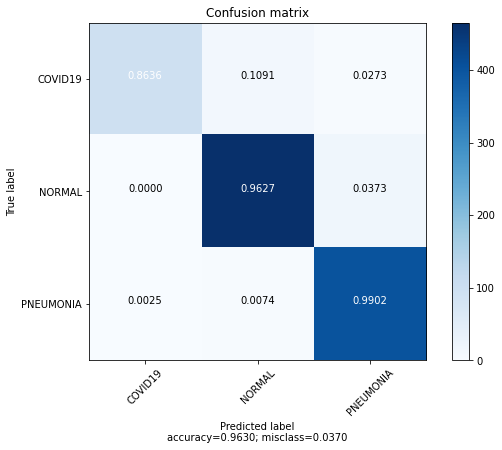

In [67]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False):

    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()


plot_confusion_matrix(cm,['COVID19','NORMAL','PNEUMONIA'],
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True)